In [2]:
import numpy as np
import matplotlib.pyplot as plt

Q5: 这里应该用n*p来看1的个数，数个数 还有应该证明他们是uncorrelated(将0换成-1)

In [3]:
def source(n,p):
    "n: number of length; P: probability"
    # Generate N uniform random variable
    u = np.random.rand(n)
    # u<p, ture;otherwise false
    b = (u < p).astype(int)
    return b
# TEST
if __name__ == "__main__":
    test_bits = source(1024, 0.5)
    print(f"the first 20 bits: {test_bits[:20]}")
    print(f"mean value of the bits: {np.mean(test_bits)} ")

the first 20 bits: [1 0 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1]
mean value of the bits: 0.4765625 


Q6

In [4]:
def prbs_source(N):
    """
    使用 LFSR 生成长度为 N 的伪随机序列 (PRBS-7)。
    多项式: x^7 + x^6 + 1
    """
    # 初始化寄存器 (7位，初始不能全为0)
    register = [1, 1, 1, 1, 1, 1, 1]
    b = np.zeros(N, dtype=int)

    for i in range(N):
        # 取出输出位 (通常取最后一个)
        out = register[-1]
        b[i] = out

        # 计算反馈位: tap 6 XOR tap 7 (索引 5 和 6)
        feedback = register[5] ^ register[6]

        # 移位操作: 插入反馈位到头部，移除尾部
        register = [feedback] + register[:-1]

    return b

！Q7 这一问还需要解释一下constellation为什么是-3 -1 1 3;hamming distance =1的好处是即使SER不好，BER也不会太差，就一个bit错了;


老师这里的格式是mapper(b,const,mapping):const是星座图、mapping是dictionary，比如0000对应-3-3i

Recursive, divide by 4.

In [5]:
def mapper(b):
    """
    Map bits to symbols.
    Parameters:
        b: input bit array
    Returns:
        s: complex symbol array
    """
    # 1. Check bit length
    if len(b) % 4 != 0:
        raise ValueError("The number of bits must be a multiple of 4 (for 16-QAM)")

    # 2. Reshape bits into an (N/4, 4) matrix
    # Each row represents 4 bits of one symbol: [b0, b1, b2, b3]
    n_syms = len(b) // 4
    bits_matrix = b.reshape(n_syms, 4)

    # 3. Separate real-part bits and imaginary-part bits
    # The first two columns are for the real part
    bits_real = bits_matrix[:, 0:2]
    # The last two columns are for the imaginary part
    bits_imag = bits_matrix[:, 2:4]

    # 4. Convert binary to decimal indices (0, 1, 2, 3)
    # e.g., [1, 0] -> 1*2 + 0*1 = 2
    # This step is prepared for the look-up table
    idx_real = bits_real[:, 0] * 2 + bits_real[:, 1]
    idx_imag = bits_imag[:, 0] * 2 + bits_imag[:, 1]

    # 5. Define the mapping table
    # Index: 0(00), 1(01), 2(10), 3(11)
    # Value: -3,    -1,    +3,    +1
    mapping_table = np.array([-3, -1, 3, 1])

    # 6. Look up coordinate values
    real_parts = mapping_table[idx_real]
    imag_parts = mapping_table[idx_imag]

    # 7. Combine into complex numbers
    s = real_parts + 1j * imag_parts

    # 8. Calculate average energy
    E = np.mean(np.abs(s)**2)
    print(f"Average Energy E = {E}")

    return s

Average Energy E = 10.281250000000002


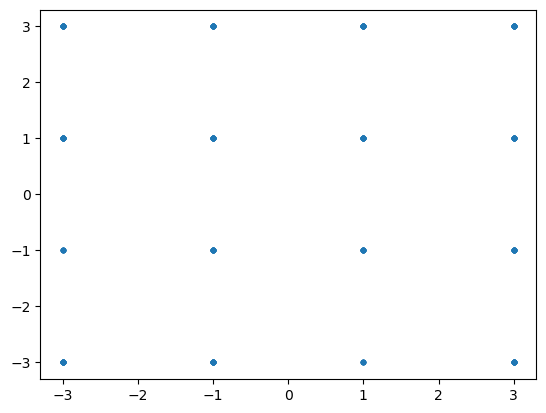

In [6]:
b = source(1024, 0.5)
s = mapper(b)
plt.plot(np.real(s),np.imag(s),".")

Q8 证明

Q9 课堂sinc 回家RRC; e.g. B=2

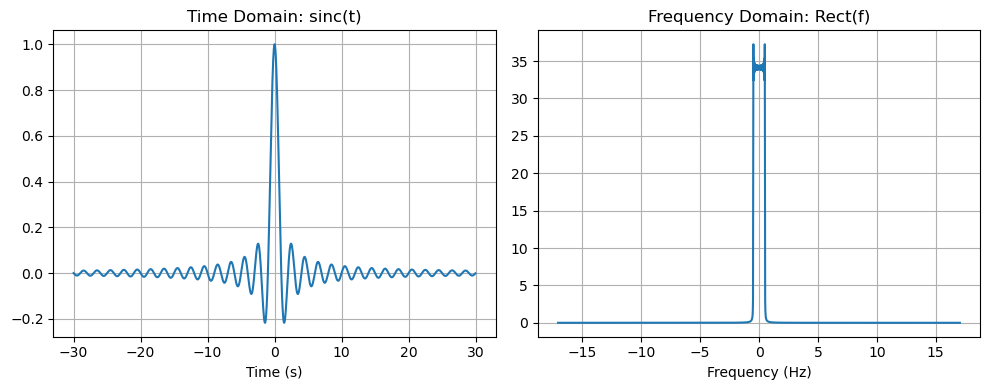

In [12]:
T = 60 # Time window
N = 2 ** 11 # Num of sampling points
dt = T / N # Step size of time
t = np.arange(-T/2, T/2, dt)
F = 1 / dt
df = 1/ T
f = np.arange(-N/2, N/2) * df
y = np.sinc(t)
Y = np.fft.fft(y)
Y_shifted = np.fft.fftshift(Y)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(t, y)
plt.title("Time Domain: sinc(t)")
plt.xlabel("Time (s)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(f, np.abs(Y_shifted))
plt.title("Frequency Domain: Rect(f)")
plt.xlabel("Frequency (Hz)")
plt.grid(True)
plt.tight_layout()
plt.show()

# def mod_sinc(s,B=2,t):
#     '''
#     :param s: symbol array
#     :param B: bandwidth
#     :param t: time
#     :return: q
#     '''
#     q_t = np.zeros(l)